In [1]:
import sklearn
sklearn.__version__

'0.20.2'

# Setting up the modules 

In [2]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# analysis related modules
from scipy.stats import entropy, spearmanr, describe
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [4]:
from utils.utils import rmse, rocauc, ci
from tqdm import tqdm_notebook

Using TensorFlow backend.
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [5]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
# tf.logging.set_verbosity(tf.logging.ERROR)

# import dataset 

In [6]:
## filtering the original data
# df_contexts = pd.read_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context.pickle')
# df_contexts = df_contexts[df_contexts['mean_rating']!=0] # sentences with inappropriate score counts
# df_contexts = df_contexts.dropna()                       # rows with missing features
# df_contexts = df_contexts.reset_index(drop=True)
# df_contexts.to_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context_filtered.pickle')
df_contexts = pd.read_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context_filtered.pickle')

In [7]:
df_contexts.shape # row counts from the original paper: 67833

(67831, 624)

In [8]:
# df_contexts['num_words']

In [9]:
mm_scaler = MinMaxScaler()
# info_scores = mm_scaler.fit_transform(df_contexts[['mean_rating']])
# info_scores = info_scores[:,0]
df_contexts['mm_mean_rating'] = mm_scaler.fit_transform(df_contexts[['mean_rating']])[:,0]

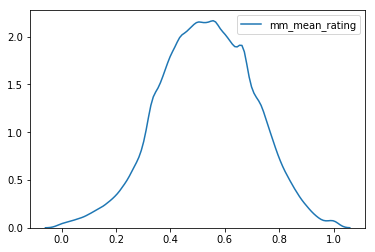

In [10]:
sns.kdeplot(df_contexts['mm_mean_rating'])

In [11]:
# pd.cut(df_contexts['mean_rating'], bins=[-float("inf"), 0, 0.5, 1, float("inf")]).value_counts(normalize=True)
df_contexts['mm_mean_rating'].describe()

count    67831.000000
mean     0.530754    
std      0.173382    
min      0.000000    
25%      0.406667    
50%      0.533333    
75%      0.666667    
max      1.000000    
Name: mm_mean_rating, dtype: float64

In [14]:
df_contexts['nwords'].describe()

count    67831.000000
mean     80.936548   
std      42.393129   
min      17.000000   
25%      55.000000   
50%      66.000000   
75%      91.000000   
max      463.000000  
Name: nwords, dtype: float64

In [12]:
gkf = GroupKFold(n_splits=10) ## target words

# baseline0 - dummy regressor

In [29]:
from sklearn.dummy import DummyRegressor

In [30]:
gkf_split = gkf.split(df_contexts['context'], groups=df_contexts['target_word'])

res_b0_pred = []
res_b0_true = []
for train_idx, test_idx in tqdm_notebook(gkf_split, desc='cvfold'):
    train_feat = df_contexts.iloc[train_idx]['num_words'].values[:, np.newaxis]
    test_feat = df_contexts.iloc[test_idx]['num_words'].values[:, np.newaxis]
    
    train_true = df_contexts.iloc[train_idx]['mm_mean_rating'].values
    test_true = df_contexts.iloc[test_idx]['mm_mean_rating'].values
    
    mod = DummyRegressor(strategy='mean').fit(train_feat, train_true)
    pred = mod.predict(test_feat)
    res_b0_pred.append(pred)
    res_b0_true.append(test_true)

In [32]:
(ci([rmse(true, pred) for true, pred in zip(res_b0_true, res_b0_pred)], digits=3),
 ci([1-rocauc(true, pred, 0.2, "low") for true, pred in zip(res_b0_true, res_b0_pred)], digits=3),
 ci([rocauc(true, pred, 0.5, "high") for true, pred in zip(res_b0_true, res_b0_pred)], digits=3),
 ci([rocauc(true, pred, 0.8, "high") for true, pred in zip(res_b0_true, res_b0_pred)], digits=3))

((0.173, 0.17, 0.176), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# baseline1 - linear reg:sentence length 

In [33]:
gkf = GroupKFold(n_splits=10) ## target words

In [34]:
# from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

In [35]:
gkf_split = gkf.split(df_contexts['context'], groups=df_contexts['target_word'])

res_b1_pred = []
res_b1_true = []
for train_idx, test_idx in tqdm_notebook(gkf_split, desc='cvfold'):
    train_feat = df_contexts.iloc[train_idx]['num_words'].values[:, np.newaxis]
    test_feat = df_contexts.iloc[test_idx]['num_words'].values[:, np.newaxis]
    
    train_true = df_contexts.iloc[train_idx]['mm_mean_rating'].values
    test_true = df_contexts.iloc[test_idx]['mm_mean_rating'].values
    
    mod = LinearRegression().fit(train_feat, train_true)
    pred = mod.predict(test_feat)
    res_b1_pred.append(pred)
    res_b1_true.append(test_true)

In [36]:
(ci([rmse(true, pred) for true, pred in zip(res_b1_true, res_b1_pred)], digits=3),
 ci([1-rocauc(true, pred, 0.2, "low") for true, pred in zip(res_b1_true, res_b1_pred)], digits=3),
 ci([rocauc(true, pred, 0.5, "high") for true, pred in zip(res_b1_true, res_b1_pred)], digits=3),
 ci([rocauc(true, pred, 0.8, "high") for true, pred in zip(res_b1_true, res_b1_pred)], digits=3))

((0.173, 0.17, 0.176),
 (0.511, 0.505, 0.517),
 (0.507, 0.5, 0.514),
 (0.502, 0.495, 0.509))

# baseline2 - BoW

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [14]:
gkf_split = gkf.split(df_contexts['context'], groups=df_contexts['target_word'])

res_b2_pred = []
res_b2_true = []
vectorizer = CountVectorizer(ngram_range=(1, 2)).fit(df_contexts['context'])

for train_idx, test_idx in tqdm_notebook(gkf_split, desc='cvfold'):
    train_feat = vectorizer.transform(df_contexts.iloc[train_idx]['context']).toarray()
    test_feat = vectorizer.transform(df_contexts.iloc[test_idx]['context']).toarray()
    
    train_true = df_contexts.iloc[train_idx]['mm_mean_rating'].values
    test_true = df_contexts.iloc[test_idx]['mm_mean_rating'].values
    
    mod = LinearRegression().fit(train_feat, train_true)
    pred = mod.predict(test_feat)
    res_b2_pred.append(pred)
    res_b2_true.append(test_true)

MemoryError: Unable to allocate array with shape (61058, 1456392) and data type int64

In [50]:
(ci([rmse(true, pred) for true, pred in zip(res_b2_true, res_b2_pred)], digits=3),
 ci([1-rocauc(true, pred, 0.2, "low") for true, pred in zip(res_b2_true, res_b2_pred)], digits=3),
 ci([rocauc(true, pred, 0.5, "high") for true, pred in zip(res_b2_true, res_b2_pred)], digits=3),
 ci([rocauc(true, pred, 0.8, "high") for true, pred in zip(res_b2_true, res_b2_pred)], digits=3))

ValueError: Lengths must match to compare